# Business Understanding

# Data Understanding and Cleaning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

df = pd.read_csv('data/kc_house_data.csv')

In [2]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long'],
      dtype='object')

## Adding and Adjusting Columns

There are a few relatively obvious features we can create that should help us understand this data set:
- price-per-square-foot (from price and sqft_living_area)
- city (from address)
- state (from address)
- zip (from address)

In [3]:
df['ppsqft'] = df['price'] / df['sqft_living']
df['state'] = df['address'].apply(lambda x: str(x).split(' ')[-4])
df['zip'] = df['address'].apply(lambda x: str(x).split(' ')[-3].replace(',', ''))
df['city'] = df['address'].apply(lambda x: str(x).split(',')[-3].strip())

View, condition, and grade should all be label-encoded.

In [4]:
def view(x):
    if x == 'NONE':
        return 0
    elif x == 'FAIR':
        return 1
    elif x == 'AVERAGE':
        return 2
    elif x == 'GOOD':
        return 3
    elif x == 'EXCELLENT':
        return 4

df['view'] = df['view'].apply(lambda x: view(x))

def condition(x):
    if x == 'Poor':
        return 0
    elif x == 'Fair':
        return 1
    elif x == 'Average':
        return 2
    elif x == 'Good':
        return 3
    elif x == 'Very Good':
        return 4

df['condition'] = df['condition'].apply(lambda x: condition(x))

df['grade'] = df['grade'].apply(lambda x: int(x[:2].strip()))

The 'year renovated' has a zero value for most of the entries, which is not mathematically compatible. 

In [5]:
df['year_of_sale'] = df['date'].apply(lambda x: int(x[-4:]))
df['age'] = df['year_of_sale'] - df['yr_built']
df['years_since_renovation'] = df.apply(
    lambda x: x.age if x.yr_renovated == 0 else x.year_of_sale - x.yr_renovated, axis=1)

## Exploring the Data Via Maps and Removing Out-of-Range Records

Let's get an idea of where these listings are. We can do so by making a scatterplot of the longitude and latitude entries.

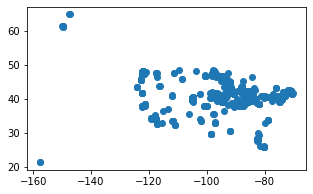

In [6]:
fig, ax = plt.subplots(figsize=(5,3))

ax.scatter(df['long'],df['lat']);

For some reason, this appears to include listings from nearly all 50 states, while were supposed to be focusing on just one county in Washington.

In [7]:
print('Total listings: ' + str(len(df)))
print('Out of state listings: ' + str(len(df[df['state'] != 'Washington'])))

Total listings: 30155
Out of state listings: 910


We'll get rid of out-of-state listings and look just at Washington.

In [8]:
# group the indices of 'bad' records in a set to be dropped
out_of_range = set(df[df['state'] != 'Washington'].index)

# make a fresh copy of the temporary dataframe, df_map
df_map = df.copy()

# drop the bad indices
df_map.drop(out_of_range, inplace=True)

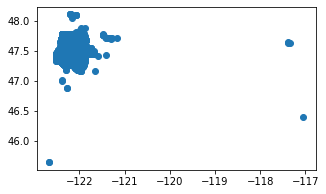

In [9]:
fig, ax = plt.subplots(figsize=(5,3))

ax.scatter(df_map['long'],df_map['lat']);

There are still some far-flung properties in places like Spokane. We can look up cities using long/lat approaching from all directions and eliminate anything that isn't in King County.

In [10]:
# from the east
df_map.groupby('city').mean()[['long']].sort_values('long', ascending=False)[:5]

,long
city,
Clarkston,-117.056550
Spokane,-117.375921
Skykomish,-121.332524
Snoqualmie Pass,-121.417590
Baring,-121.470469


In [11]:
# update the set of indices of 'bad' records to be dropped
out_of_range.update(df[df['city'] == 'Clarkston'].index)
out_of_range.update(df[df['city'] == 'Spokane'].index)

# make a fresh copy of the temporary dataframe, df_map
df_map = df.copy()

# drop the bad indices
df_map.drop(out_of_range, inplace=True)

In [12]:
# from the south
df_map.groupby('city').mean()[['lat']].sort_values('lat', ascending=True)[:5]

,lat
city,
Vancouver,45.636805
Eatonville,46.876426
Spanaway,47.002985
Puyallup,47.178090
Enumclaw,47.212415


In [13]:
# update the set of indices of 'bad' records to be dropped
out_of_range.update(df[df['city'] == 'Vancouver'].index)
out_of_range.update(df[df['city'] == 'Eatonville'].index)
out_of_range.update(df[df['city'] == 'Spanaway'].index)
out_of_range.update(df[df['city'] == 'Puyallup'].index)

# make a fresh copy of the temporary dataframe, df_map
df_map = df.copy()

# drop the bad indices
df_map.drop(out_of_range, inplace=True)

This region features two cities, Milton and Auburn, that spill over into neighboring Pierce County to the south.

In [14]:
df_map[
       (df_map['lat'] < 47.257510) &
       (df_map['long'] < -122.144411)
      ][['address', 'price', 'sqft_living', 'sqft_lot', 'bedrooms']]

,address,price,sqft_living,sqft_lot,bedrooms
1236,"4018 South 384th Street, Auburn, Washington 98...",380000.0,1250,18700,3
24148,"1901 Alder Place, Milton, Washington 98354, Un...",610000.0,1610,9644,4
27679,"98 27th Avenue, Milton, Washington 98354, Unit...",550000.0,1840,9851,4


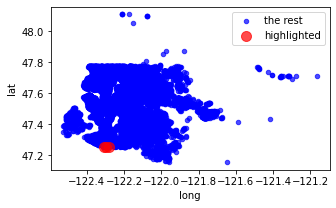

In [15]:
highlight = df_map[
#     (df_map['lat'] > 47.4) &
       (df_map['lat'] < 47.257510) &
#        (df_map['long'] > -121.93) &
       (df_map['long'] < -122.144411)
      ].index

blue_dots = df_map.drop(highlight)
red_dots = df_map.loc[highlight]

fig, ax = plt.subplots(figsize=(5,3))

blue_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='blue', ax=ax, label='the rest')
red_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='red', s=100, ax=ax, label='highlighted')

ax.legend();

There are 3 more listings that are essentially contiguous with the rest of the records, but technically belong to another county. They don't otherwise appear anomalous, so we'll keep them.

In [16]:
# from the north
df_map.groupby('city').mean()[['lat']].sort_values('lat', ascending=False)[:8]

,lat
city,
Tulalip,48.111504
Arlington,48.100735
Marysville,48.082740
Monroe,47.824948
Snohomish,47.811287
Baring,47.760969
Lake Forest Park,47.759078
Bothell,47.757407


In [17]:
# update the set of indices of 'bad' records to be dropped
out_of_range.update(df[df['city'] == 'Tulalip'].index)
out_of_range.update(df[df['city'] == 'Arlington'].index)
out_of_range.update(df[df['city'] == 'Marysville'].index)
out_of_range.update(df[df['city'] == 'Monroe'].index)
out_of_range.update(df[df['city'] == 'Snohomish'].index)

# make a fresh copy of the temporary dataframe, df_map
df_map = df.copy()

# drop the bad indices
df_map.drop(out_of_range, inplace=True)

In [18]:
# from the west
df_map.groupby('city').mean()[['long']].sort_values('long', ascending=True)[:5]

,long
city,
Vashon,-122.467801
Dilworth,-122.439530
Dash Point,-122.416100
White Center,-122.363360
Normandy Park,-122.343426


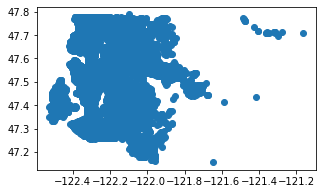

In [19]:
fig, ax = plt.subplots(figsize=(5,3))

ax.scatter(df_map['long'],df_map['lat'], color="blue");

We'll investigate the dot by itself that's above the county line.

In [20]:
df_map.sort_values('lat', ascending=False)[:3][['lat', 'long', 'city', 'zip']]

,lat,long,city,zip
24605,47.78983,-122.097078,Woodinville,98077
25634,47.77764,-122.376830,Shoreline,98177
29110,47.77758,-122.352405,Shoreline,98133


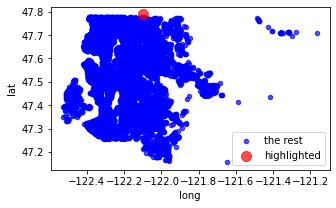

In [21]:
highlight = [24605]

blue_dots = df_map.drop(highlight)
red_dots = df_map.loc[highlight]

fig, ax = plt.subplots(figsize=(5,3))

blue_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='blue', ax=ax, label='the rest')
red_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='red', s=100, ax=ax, label='highlighted')

ax.legend();

The single northernmost anomalous dot is at a latitude located neither in King County nor in Woodinville. It could be an error, but we wouldn't know how to correct it, so we'll drop it.

In [22]:
# update the set of indices of 'bad' records to be dropped
out_of_range.add(24605)

# make a fresh copy of the temporary dataframe, df_map
df_map = df.copy()

# drop the bad indices
df_map.drop(out_of_range, inplace=True)

Now we'll look at the strip of dots to the northeast along State Highway 2.

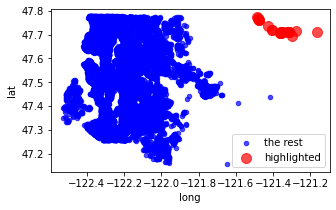

In [23]:
highlight = df_map[(df_map['lat'] > 47.6) & (df_map['long'] > -121.6)].index

blue_dots = df_map.drop(highlight)
red_dots = df_map.loc[highlight]

fig, ax = plt.subplots(figsize=(5,3))

blue_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='blue', ax=ax, label='the rest')
red_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='red', s=100, ax=ax, label='highlighted')

ax.legend();

In [24]:
df_map[(df_map['lat'] > 47.6) & (df_map['long'] > -121.6)]['city'].value_counts()

Skykomish    19
Baring        7
Name: city, dtype: int64

There are 26 listings along State Highway 2 that are pretty far out from the main urban area. Rather than drop them, we'll tag them with a new column, "hwy2".

In [25]:
df['hwy2'] = df['city'].apply(lambda x: 1 if x == 'Skykomish' or x == 'Baring' else 0)

Now we'll look at the stray dot to the south.

In [26]:
df_map[(df_map['lat'] < 47.2) & (df_map['long'] > -121.8)][['city', 'lat', 'long', 'address']]

,city,lat,long,address
2930,Enumclaw,47.155265,-121.648225,"52309 SE 496th Pl, Enumclaw, Washington 98022,..."


In [27]:
df[df['city'] == 'Enumclaw']['zip'].value_counts()

98022    459
98092      1
Name: zip, dtype: int64

In [28]:
df[df['zip'] == '98092']['city'].value_counts()

Auburn      608
Enumclaw      1
Name: city, dtype: int64

This appears to be a remote community, far from the city it claims (Enumclaw) or the city normally associated with its zip code (Auburn). It doesn't appear to be an error, but it still represents a community with no immediate neighbors for comparison. As such, we'll drop it.

In [29]:
# update the set of indices of 'bad' records to be dropped
out_of_range.add(2930)

# make a fresh copy of the temporary dataframe, df_map
df_map = df.copy()

# drop the bad indices
df_map.drop(out_of_range, inplace=True)

Now we'll look at the stray dots in the middle by pinching the latitude and searching longitude from east to west.

In [30]:
df_map[(df_map['lat'] > 47.3)
       & (df_map['lat'] < 47.6)].sort_values('long', ascending=False)[:8][['lat', 'long', 'city', 'zip']]

,lat,long,city,zip
17663,47.437030,-121.41759,Snoqualmie Pass,98045
20216,47.413610,-121.58837,North Bend,98045
14924,47.444770,-121.67469,North Bend,98045
11277,47.444905,-121.67554,North Bend,98045
28815,47.444655,-121.67839,North Bend,98045
28816,47.444745,-121.67879,North Bend,98045
8473,47.496180,-121.68674,North Bend,98045
15081,47.480100,-121.69844,North Bend,98045


Investigating these coordinates on Google Maps shows that he first three of these are something like the "Enumclaw" anomaly discussed earlier, but everything else appears to belong to a cluster worth keeping. We'll drop those three.

In [31]:
# update the set of indices of 'bad' records to be dropped
out_of_range.update(df_map[(df_map['lat'] > 47.3)
                           & (df_map['lat'] < 47.6)].sort_values('long', ascending=False)[:3].index)

# make a fresh copy of the temporary dataframe, df_map
df_map = df.copy()

# drop the bad indices
df_map.drop(out_of_range, inplace=True)

Now we'll look at two final listings that appear remotely located from the rest.

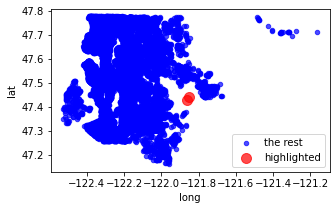

In [32]:
highlight = df_map[(df_map['lat'] > 47.4) &
       (df_map['lat'] < 47.475) &
       (df_map['long'] > -121.93) &
       (df_map['long'] < -121.8)
      ].index

blue_dots = df_map.drop(highlight)
red_dots = df_map.loc[highlight]

fig, ax = plt.subplots(figsize=(5,3))

blue_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='blue', ax=ax, label='the rest')
red_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='red', s=100, ax=ax, label='highlighted')

ax.legend();

In [33]:
df_map[(df_map['lat'] > 47.4) &
       (df_map['lat'] < 47.475) &
       (df_map['long'] > -121.93) &
       (df_map['long'] < -121.8)
      ][['address', 'price', 'grade', 'condition', 'heat_source', 'sqft_living', 'sqft_lot', 'bathrooms']]

,address,price,grade,condition,heat_source,sqft_living,sqft_lot,bathrooms
20448,"19109 364th Avenue Southeast, Maple Valley, Wa...",885000.0,8,2,Gas,2240,305355,2.0
24342,"17800 364th Avenue Southeast, Maple Valley, Wa...",1115000.0,4,2,NaN,660,1210096,1.0


One of these is a "low grade" 1-bedroom that sold for $1.115 million, which raises enough questions. It would seem fair to drop both of them.

In [34]:
# update the set of indices of 'bad' records to be dropped
out_of_range.update([20448, 24342])

# make a fresh copy of the temporary dataframe, df_map
df_map = df.copy()

# drop the bad indices
df_map.drop(out_of_range, inplace=True)

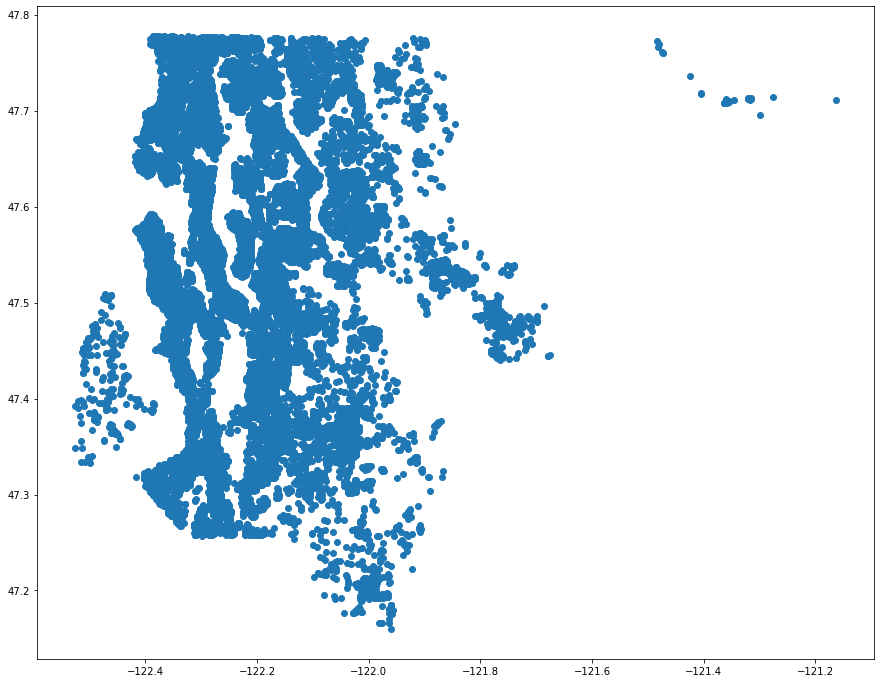

In [35]:
fig, ax = plt.subplots(figsize=(15,9))

ax.scatter(df_map['long'],df_map['lat']);

Geographically, at least, this looks like the data we want to work with.

In [36]:
print('We have dropped ' + str(len(df) - len(df_map)) + ' records, about '
      + str(round(100*(1 - len(df_map) / len(df)),2)) + '% of them.')

We have dropped 946 records, about 3.14% of them.


We'll lock in the changes to the main dataframe.

In [37]:
df = df_map.copy()

Now we'll build some functions that will give us a list of everyone's closest neighbors for the purpose of comparing values with listings nearby.

In [38]:
# compute the distance in feet between two coordinates
def distance(lat1, long1, lat2, long2):
    x = abs(lat2-lat1)*364732.89
    y = abs(long2-long1)*249526.96
    return np.sqrt(x**2 + y**2)

The 'neighbors' function was developed over many drafts. The goal is to generate a list of neighbors for each listing. The criteria for inclusion are 1) proximity, as measured by the distance function, and 2) same or similar number of bedrooms. It isn't convenient or feasible to generate the same number of neighbors for every listing nor to limit each list of neighbors to the same radius for all listings. The best version of the function targets a neighbor list between 10 and 30 records long, starts with a radius of 250 feet, and either expands or contracts the radius until it generates a list within the desired size range.

In [39]:
def neighbors(brs, lat, long, radius, min_neighbor_count, max_neighbor_count):
    # generate an initial list according to number of bedrooms
    if brs < 2:
        neighbor_list = df[
            (df['bedrooms'] < 2) &
            (distance(lat, long, df['lat'], df['long']) < radius)
        ].index
    elif brs == 2:
        neighbor_list = df[
            (df['bedrooms'] == 2) &
            (distance(lat, long, df['lat'], df['long']) < radius)
        ].index
    elif brs == 3:
        neighbor_list = df[
            (df['bedrooms'] == 3) &
            (distance(lat, long, df['lat'], df['long']) < radius)
        ].index
    elif brs == 4:
        neighbor_list = df[
            (df['bedrooms'] == 4) &
            (distance(lat, long, df['lat'], df['long']) < radius)
        ].index
    elif brs == 5:
        neighbor_list = df[
            (df['bedrooms'] == 5) &
            (distance(lat, long, df['lat'], df['long']) < radius)
        ].index
    elif brs > 5:
        neighbor_list = df[
            (df['bedrooms'] > 5) &
            (distance(lat, long, df['lat'], df['long']) < radius)
        ].index
    
    # expand the radius and rerun if the list is too small
    if len(neighbor_list) < min_neighbor_count:
        radius *= 3.5
        return neighbors(brs, lat, long, radius, min_neighbor_count, max_neighbor_count)
    # contract the radius and rerun if the list is too long
    elif len(neighbor_list) > max_neighbor_count:
        radius *= 0.75
        return neighbors(brs, lat, long, radius, min_neighbor_count, max_neighbor_count)
    # accept the list otherwise
    else:
        return neighbor_list

This function helps generate new columns that show the median of a certain column value, e.g. living area, for all of a listing's neighbors (from its neighbor list).

In [40]:
def nearby(neighbor_list, column):
    return df.loc[neighbor_list][column].median()

The cell below creates the neighbor list and generates the 'nearby' features.

In [41]:
# THIS CELL TAKES SEVERAL MINUTES TO RUN

df['neighbor_list'] = df.apply(lambda x: neighbors(x.bedrooms, x.lat, x.long, 250, 10, 30), axis=1)
df['nearby_price'] = df.apply(lambda x: nearby(x.neighbor_list, 'price'), axis=1)
df['nearby_sqft_living'] = df.apply(lambda x: nearby(x.neighbor_list, 'sqft_living'), axis=1)
df['nearby_sqft_lot'] = df.apply(lambda x: nearby(x.neighbor_list, 'sqft_lot'), axis=1)
df['nearby_ppsqft'] = df.apply(lambda x: nearby(x.neighbor_list, 'ppsqft'), axis=1)
df['nearby_age'] = df.apply(lambda x: nearby(x.neighbor_list, 'age'), axis=1)

These new features allow for more developed exploration of the data.

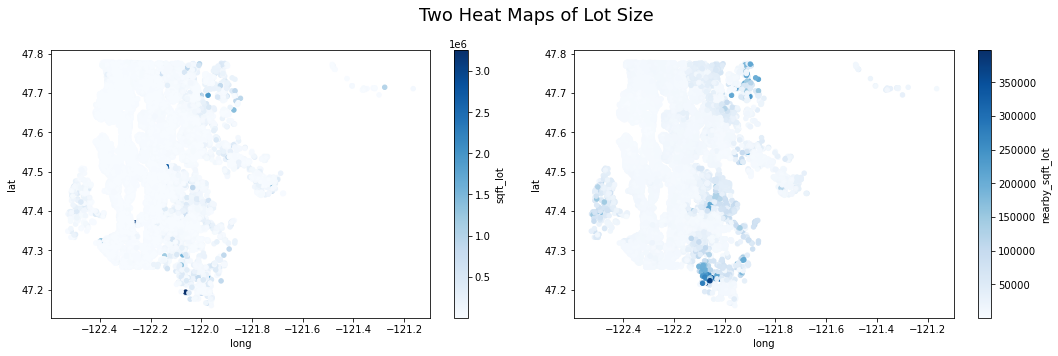

In [42]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))

df.plot.scatter(x='long', y='lat', c='sqft_lot', cmap='Blues', ax=ax1)
df.plot.scatter(x='long', y='lat', c='nearby_sqft_lot', cmap='Blues', ax=ax2)
fig.suptitle('Two Heat Maps of Lot Size', size=18)
fig.tight_layout();

The second map shows a little more clearly where the bigger lots tend to be.

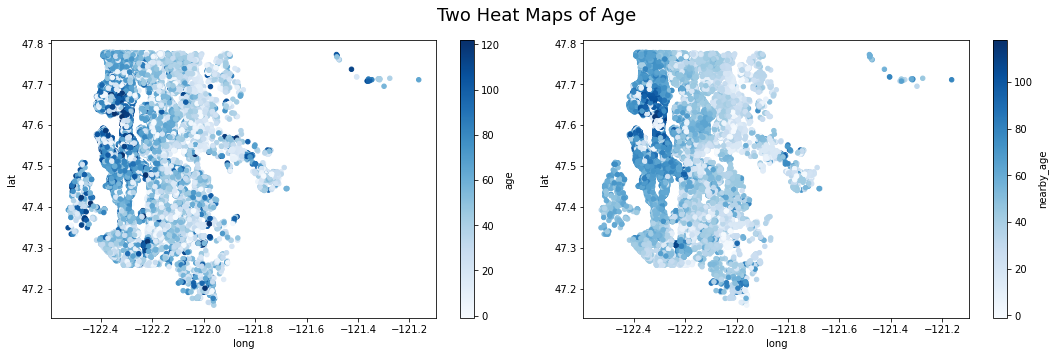

In [43]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))

df.plot.scatter(x='long', y='lat', c='age', cmap='Blues', ax=ax1)
df.plot.scatter(x='long', y='lat', c='nearby_age', cmap='Blues', ax=ax2)
fig.suptitle('Two Heat Maps of Age', size=18)
fig.tight_layout();

The second map smooths out the differences to tell a clearer picture of the sequence of development. It also shows that there are pockets of newer developments amid older areas, possibly indicating gentrification

We can also use the neighbor list features to identify anomalous records that are possibly just errors. We can give each listing a score based on the factors by which it differs from its neighbors in certain values. For example, we'll see a listing whose living area ("3 sq ft") is orders of magnitude smaller than its neighbors.

(An earlier effort at this identified too many 'anomalies' by virtue of their exceptionally large lot areas, so we'll just look for exceptional values in price and living area.)

In [44]:
def anom(p, liv, np, nliv):
    return max(p/np, np/p) + max(liv/nliv, nliv/liv)

In [45]:
df['anomalous'] = df.apply(lambda x: anom(x.price, x. sqft_living,
                           x.nearby_price, x.nearby_sqft_living),axis=1)

In [46]:
df['anomalous'].describe()

count    29209.000000
mean         2.618734
std          4.893226
min          2.000000
25%          2.188657
50%          2.364474
75%          2.671687
max        814.901159
Name: anomalous, dtype: float64

In [47]:
df.sort_values('anomalous', ascending=False)[:20][['anomalous',
    'bedrooms', 'ppsqft', 'nearby_ppsqft', 'price', 'nearby_price',
    'sqft_living', 'nearby_sqft_living', 'address']]

,anomalous,bedrooms,ppsqft,nearby_ppsqft,price,nearby_price,sqft_living,nearby_sqft_living,address
14977,814.901159,4,601000.000000,444.015444,1803000.0,1150000.0,3,2440.0,"31072 Northeast 165th Street, Duvall, Washingt..."
25830,54.588784,5,7.117730,391.854505,30108.0,1610000.0,4230,3795.0,"34920 Southeast Fall City-Snoqualmie Road, Fal..."
6430,50.848244,4,6.920415,659.058450,40000.0,1957500.0,5780,3025.0,"2030 250th Place Northeast, Sammamish, Washing..."
23470,48.087546,1,15073.529412,876.209677,30750000.0,675625.0,2040,792.5,"1620 Lake Washington Boulevard, Seattle, Washi..."
9125,47.965657,5,11.695703,467.289720,29941.0,1400000.0,2560,3090.0,"15724 124th Avenue Northeast, Woodinville, Was..."
12688,34.433333,5,18.367347,443.548387,45000.0,1500000.0,2450,2695.0,"6109 Northeast 190th Street, Kenmore, Washingt..."
21793,32.839287,3,11.880603,596.289107,27563.0,861500.0,2320,1465.0,"1528 19th Avenue, Seattle, Washington 98122, U..."
17140,31.284424,4,26.719704,597.549608,54241.0,1630500.0,2030,2485.0,"15244 Southeast 49th Street, Bellevue, Washing..."
20406,28.185133,3,15.190957,454.031465,28559.0,772000.0,1880,1630.0,"417 Hoquiam Place Northeast, Renton, Washingto..."
4487,26.677343,4,13.895640,405.759162,47801.0,1222500.0,3440,3120.0,"18489 Renton Maple Valley Road Southeast, Mapl..."


We'll address 20 of the worst offenders. Looking up each address on Zillow, we can see which ones appear to have erroneous information about price or living area.

In [48]:
df.at[14977, 'sqft_living'] = 3325
df.at[25830, 'price'] = 1542300
df.at[6430, 'price'] = 4060000
anomalies = set([12688])
df.at[21793, 'price'] = 1400000
df.at[17140, 'price'] = 1462900
df.at[20406, 'price'] = 734500
df.at[1145, 'price'] = 1075300
df.at[7577, 'price'] = 1500000
df.at[27793, 'price'] = 1233600
df.at[5811, 'sqft_living'] = 5805
df.at[28216, 'price'] = 1600000
df.at[18046, 'price'] = 714300
df.at[14544, 'price'] = 976000

df.drop(anomalies, inplace=True)

In [49]:
df['anomalous'] = df.apply(lambda x: anom(x.price, x. sqft_living,
                           x.nearby_price, x.nearby_sqft_living),axis=1)

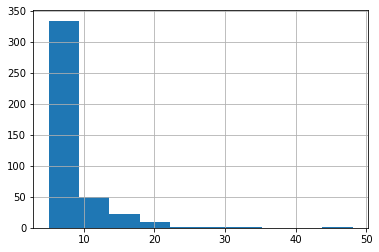

In [50]:
df[df['anomalous'] > 5]['anomalous'].hist();

In [51]:
df.sort_values('anomalous', ascending=False)[:8][['anomalous',
    'bedrooms', 'ppsqft', 'nearby_ppsqft', 'price', 'nearby_price',
    'sqft_living', 'nearby_sqft_living', 'address']]

,anomalous,bedrooms,ppsqft,nearby_ppsqft,price,nearby_price,sqft_living,nearby_sqft_living,address
23470,48.087546,1,15073.529412,876.209677,30750000.0,675625.0,2040,792.5,"1620 Lake Washington Boulevard, Seattle, Washi..."
9125,47.965657,5,11.695703,467.289720,29941.0,1400000.0,2560,3090.0,"15724 124th Avenue Northeast, Woodinville, Was..."
5811,31.542857,0,48103.448276,930.232558,13950000.0,600000.0,5805,700.0,"5045 Forest Avenue Southeast, Mercer Island, W..."
4487,26.677343,4,13.895640,405.759162,47801.0,1222500.0,3440,3120.0,"18489 Renton Maple Valley Road Southeast, Mapl..."
14797,25.559767,3,27.173913,698.824877,50000.0,1224500.0,1840,1720.0,"6221 37th Avenue Northeast, Seattle, Washingto..."
20157,23.580655,3,20.655629,469.483568,31190.0,703000.0,1510,1450.0,"13726 Midvale Ave N, Seattle, Washington 98133..."
8557,22.180165,2,37.479452,409.722222,27360.0,560000.0,730,1250.0,"320 South 184th Street, Burien, Washington 981..."
26406,22.063232,3,36.309524,450.980392,30500.0,625000.0,840,1320.0,"7924 15th Avenue Southwest, Seattle, Washingto..."


In [52]:
len(df[df['anomalous'] > 10])

73

It's not really clear how far we should go with this. There remain plenty of records that might warrant revision. Perhaps we're ready to take a shot at the baseline model.

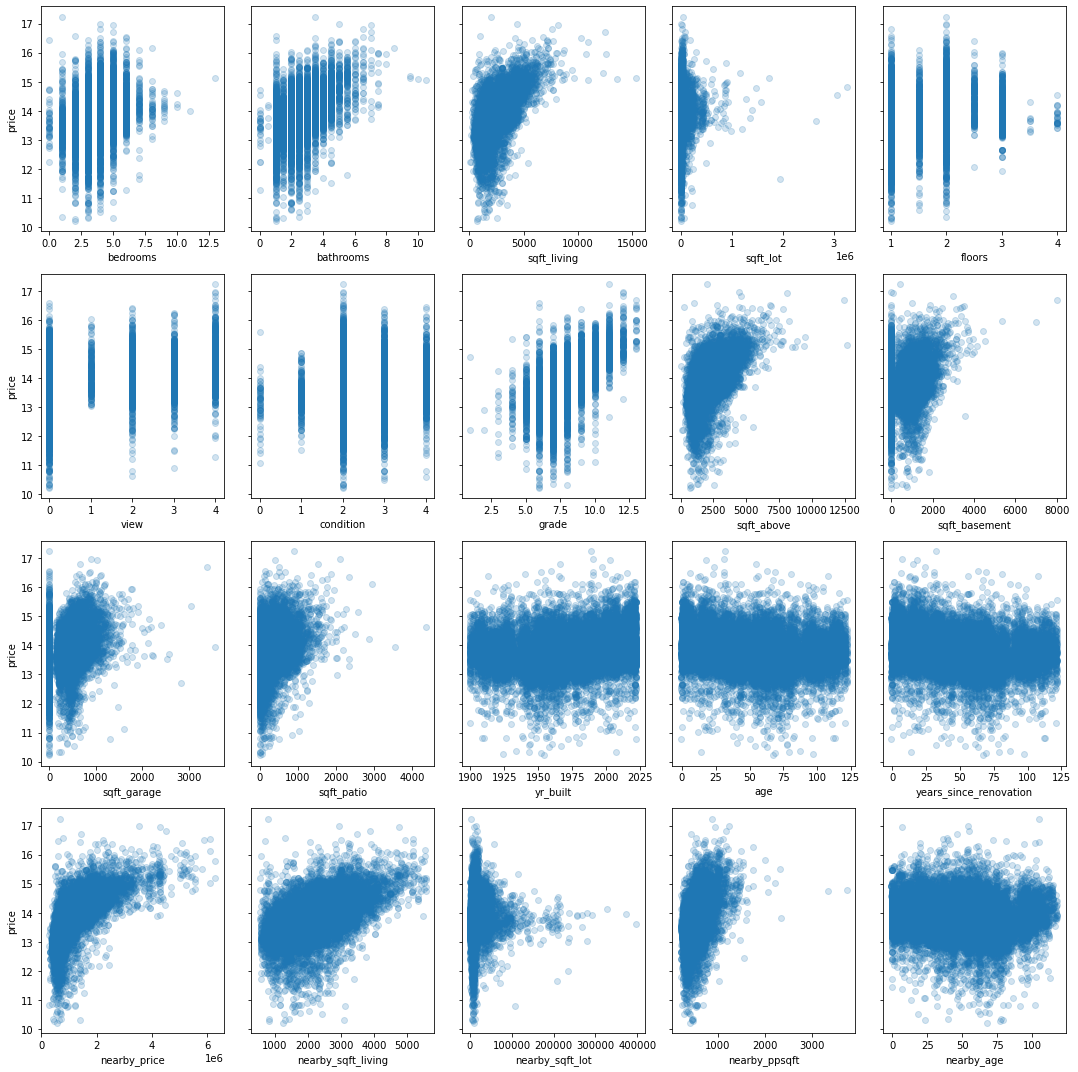

In [76]:
df_log = df.copy()

df_log['price'] = np.log(df['price'])

y = df_log['price']
X = df.drop(['id', 'date', 'price', 'waterfront', 'greenbelt', 'nuisance', 'heat_source', 'sewer_system',
             'yr_renovated', 'address', 'lat', 'long', 'ppsqft', 'state', 'zip', 'city', 'year_of_sale', 'hwy2',
             'neighbor_list', 'anomalous', 'gas', 'electricity', 'oil', 'solar', 'sewer_system_pub_priv', 'Bellevue']
            , axis=1)
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15,15), sharey=True)
for i, column in enumerate(X.columns): # Locate applicable axes
    row = i // 5
    col = i % 5
    ax = axes[row][col]
    # Plot feature vs. y and label axes
    ax.scatter(X[column], y, alpha=0.2)
    ax.set_xlabel(column)
    if col == 0:
        ax.set_ylabel('price')
fig.tight_layout()

# Modeling
## Baseline Model

We'll start with a baseline model using all the data from the listings we've narrowed down so far

In [53]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long', 'ppsqft', 'state', 'zip',
       'city', 'year_of_sale', 'age', 'years_since_renovation', 'hwy2',
       'neighbor_list', 'nearby_price', 'nearby_sqft_living',
       'nearby_sqft_lot', 'nearby_ppsqft', 'nearby_age', 'anomalous'],
      dtype='object')

### Prepare the Columns

In [54]:
numeric_continuous = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio',
                      'nearby_price', 'nearby_sqft_living', 'nearby_sqft_lot', 'nearby_ppsqft',
                      'age', 'nearby_age', 'years_since_renovation']
numeric_discrete = ['bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'grade']
categorical = ['waterfront', 'greenbelt', 'nuisance', 'heat_source', 'sewer_system',
              'zip', 'city', 'hwy2']

To prepare the features for the model, we'll need to ...
- shift zero to the median where applicable
- shift zero to something else neutral where applicable*
- one-hot encode the categorical variables

\* We've set these "neutral" values to the following:
- 3 bedrooms
- 2.5 bathrooms
- 1 floor
- average condition
- average grade

In [55]:
df_numeric_continuous = df[numeric_continuous].copy()
for column in numeric_continuous:
    df_numeric_continuous[column] = df_numeric_continuous[column] - df_numeric_continuous[column].mean()

df_numeric_discrete = df[numeric_discrete].copy()

df_numeric_discrete['bedrooms'] = df_numeric_discrete['bedrooms'] - 3
df_numeric_discrete['bathrooms'] = df_numeric_discrete['bathrooms'] - 2.5
df_numeric_discrete['floors'] = df_numeric_discrete['floors'] - 1
df_numeric_discrete['condition'] = df_numeric_discrete['condition'] - 2
df_numeric_discrete['grade'] = df_numeric_discrete['grade'] - 7

df_categorical = df[categorical].copy()
df_categorical = pd.get_dummies(df_categorical, columns = categorical)

In [56]:
df_categorical.drop(columns = ['waterfront_NO', 'greenbelt_NO', 'nuisance_NO',
                               'heat_source_Gas', 'sewer_system_PUBLIC',
                               'zip_98422', 'city_White Center', 'hwy2_0'
                              ], axis = 1, inplace = True)

Run the model

In [57]:
y = df['price']
X_baseline = pd.concat([df_numeric_continuous, df_numeric_discrete, df_categorical], axis = 1)

baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()

print(baseline_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     447.5
Date:                Sun, 26 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:17:10   Log-Likelihood:            -4.2447e+05
No. Observations:               29208   AIC:                         8.492e+05
Df Residuals:                   29060   BIC:                         8.505e+05
Df Model:                         147                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const     

### Evaluation

This model explains 69.2% of the variation.

A "baseline" home costs a bit more than $1 million.

In observing the p-values, we see that we should definitely remove:
- garage area
- Greenbelt
- hwy2

The more common heat sources seemed relevant. We'll try a new version of the heat_source column where we encode separately for the four types: Electricity, Gas, Oil, and Solar. (The ones with Solar will be encoded for multiple columns.)

The sewer system seems relevant but confused by the small number of "restricted" systems. We'll reset that column to only feature two options, public and private.

Most of the zip codes were not relevant. Upon closer look, the ones that were relevant were all concentrated in or adjacent to the city of Bellevue. We'll reset the zip and city categorical columns to only convey inclusion in that one area.

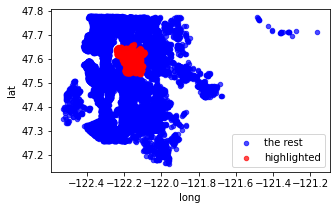

In [58]:
Bellevue = ['98004', '98005', '98006', '98007', '98008', '98039']
Bellevue_indices = []

for zip_ in Bellevue:
    Bellevue_indices.extend(df[df['zip'] == zip_].index)
    
blue_dots = df_map.drop(Bellevue_indices)
red_dots = df_map.loc[Bellevue_indices]

fig, ax = plt.subplots(figsize=(5,3))

blue_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='blue', ax=ax, label='the rest')
red_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='red', ax=ax, label='highlighted')

ax.legend();

In [59]:
df['gas'] = df['heat_source'].apply(lambda x: 1 if str(x)[:3] == 'Gas' else 0)
df['electricity'] = df['heat_source'].apply(lambda x: 1 if str(x)[:3] == 'Ele' else 0)
df['oil'] = df['heat_source'].apply(lambda x: 1 if str(x)[:3] == 'Oil' else 0)
df['solar'] = df['heat_source'].apply(lambda x: 1 if str(x)[-5:] == 'Solar' else 0)

df['sewer_system_pub_priv'] = df['sewer_system'].apply(lambda x: 'Public' if str(x)[:6] == 'PUBLIC' else 'Private')

df['Bellevue'] = df['zip'].apply(lambda x: 'YES' if x in Bellevue else 'NO')

In [60]:
numeric_continuous = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_patio',
                      'nearby_price', 'nearby_sqft_living', 'nearby_sqft_lot', 'nearby_ppsqft',
                      'age', 'nearby_age', 'years_since_renovation']
numeric_discrete = ['bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'grade']
categorical = ['waterfront', 'nuisance', 'sewer_system_pub_priv', 'Bellevue']
heat = ['gas', 'electricity', 'oil', 'solar']

In [61]:
df_numeric_continuous = df[numeric_continuous].copy()
for column in numeric_continuous:
    df_numeric_continuous[column] = df_numeric_continuous[column] - df_numeric_continuous[column].median()

df_numeric_discrete = df[numeric_discrete].copy()

df_numeric_discrete['bedrooms'] = df_numeric_discrete['bedrooms'] - 3
df_numeric_discrete['bathrooms'] = df_numeric_discrete['bathrooms'] - 2.5
df_numeric_discrete['floors'] = df_numeric_discrete['floors'] - 1
df_numeric_discrete['condition'] = df_numeric_discrete['condition'] - 2
df_numeric_discrete['grade'] = df_numeric_discrete['grade'] - 7

df_categorical = df[categorical].copy()
df_categorical = pd.get_dummies(df_categorical, columns = categorical)

df_heat = df[heat]

In [62]:
df_categorical.drop(columns = [
    'waterfront_NO', 'nuisance_NO', 'sewer_system_pub_priv_Public', 'Bellevue_NO'], axis = 1, inplace = True)

In [63]:
y = df['price']
X_baseline = pd.concat([
    df_numeric_continuous, df_numeric_discrete, df_categorical, df_heat
], axis = 1)

baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()

print(baseline_results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     2412.
Date:                Sun, 26 Feb 2023   Prob (F-statistic):               0.00
Time:                        16:17:11   Log-Likelihood:            -4.2499e+05
No. Observations:               29208   AIC:                         8.500e+05
Df Residuals:                   29181   BIC:                         8.503e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### Evaluation

This model explains 68.2% of the variation — it's worse!

A baseline home costs a bit more than $1 million.

The p-values tell an odd story this time. Now the following columns are terrible predicters:

- bedrooms
- Bellevue
- all heat sources except solar

In [64]:
error pls

SyntaxError: invalid syntax (<ipython-input-64-3d21e42c7674>, line 1)

In [ ]:
df['log_price'] = np.log(df['price'])

In [ ]:
y = df['log_price']
X_baseline = pd.concat([
    df_numeric_continuous, df_numeric_discrete, df_categorical, df_auxiliary
], axis = 1)

baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()

print(baseline_results.summary())

In [ ]:
df['city'].value_counts()

In [ ]:
fig, ax = plt.subplots(figsize=(15,9))

df.plot.scatter(x='long', y='lat', c='yr_built', cmap='Blues', ax=ax);

It also seems that we'll get further with a log(price) feature.

In [ ]:
df['log_price'] = np.log(df['price'])

In [ ]:
df['grade'].value_counts()

In [ ]:
blue_dots = df.drop(highlight)
red_dots = df.loc[highlight]

fig, ax = plt.subplots(figsize=(15,12))

# df.plot.scatter(x='long', y='lat', c='log(price)', cmap='Blues', ax=ax);

blue_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='blue', ax=ax, label='the rest')
red_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='red', s=100, ax=ax, label='highlighted')

ax.legend();

In [ ]:
highlight = df.loc[14977]['neighbor_list']

blue_dots = df_map.drop(highlight)
red_dots = df_map.loc[highlight]

fig, ax = plt.subplots(figsize=(15,12))

blue_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='blue', ax=ax, label='the rest')
red_dots.plot.scatter(x='long', y='lat', alpha=0.7, color='red', s=10, ax=ax, label='highlighted')

ax.legend();

In [ ]:
df.iloc[highlight]['sqft_living']

In [ ]:
df['price'].describe()

In [ ]:
df.skew()

In [ ]:
df['condition'].value_counts()

In [ ]:
df['view'].value_counts()

## comment on the baseline model

In [ ]:
# collect a list of outlier data past a certain threshold of standard deviations

threshold = 6
outliers = set()

outliers = set(df[df['price'] > df['price'].mean() + threshold * df['price'].std()].index)

len(outliers)

In [ ]:
y = df['price'].drop(outliers)
X_baseline = pd.concat([df_numeric_continuous, df_numeric_discrete, df_categorical], axis = 1).drop(outliers)

baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()

print(baseline_results.summary())

# make basic adjustments

customize one-hot encoding for heat source, given that some entries have multiple heat sources.

In [ ]:
df['gas'] = df['heat_source'].apply(lambda x: 1 if str(x)[:3] == 'Gas' else 0)
df['electricity'] = df['heat_source'].apply(lambda x: 1 if str(x)[:3] == 'Ele' else 0)
df['oil'] = df['heat_source'].apply(lambda x: 1 if str(x)[:3] == 'Oil' else 0)
df['solar'] = df['heat_source'].apply(lambda x: 1 if str(x)[-5:] == 'Solar' else 0)
del df['heat_source']

customize label-encoding for view, condition, and grade

reset the groups

In [ ]:
numeric_continuous = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_garage', 'sqft_patio']
numeric_discrete = ['bedrooms', 'bathrooms', 'floors', 'view', 'condition', 'grade', 'yr_built', 'yr_renovated']
categorical = ['waterfront', 'greenbelt', 'nuisance', 'sewer_system']
heat = ['gas', 'electricity', 'oil', 'solar']
specials = ['date', 'address', 'lat', 'long']

create dataframes from groups

shift the mean to zero for continuous variables

one-hot encode categorical variables

In [ ]:
df_numeric_continuous = df[numeric_continuous].copy()
for column in numeric_continuous:
    df_numeric_continuous[column] = df_numeric_continuous[column] - df_numeric_continuous[column].mean()

df_numeric_discrete = df[numeric_discrete].copy()

df_categorical = df[categorical].copy()
df_categorical = pd.get_dummies(df_categorical, columns = categorical)
df_categorical.drop(columns = ['waterfront_NO', 'greenbelt_NO',
                               'nuisance_NO', 'sewer_system_PUBLIC'], axis = 1, inplace = True)

df_heat = df[heat].copy()

run the model

In [ ]:
y = df['price']
X_baseline = pd.concat([df_numeric_continuous, df_numeric_discrete, df_categorical, df_heat], axis = 1)

baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()

print(baseline_results.summary())

removing bad correlations: greenbelt, heat source, (some) sewers

In [ ]:
del df_categorical['greenbelt_YES']
del df_categorical['sewer_system_PRIVATE RESTRICTED']
del df_categorical['sewer_system_PUBLIC RESTRICTED']

run the model

In [ ]:
y = df['price']
X_baseline = pd.concat([df_numeric_continuous, df_numeric_discrete, df_categorical, df_heat], axis = 1)

baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()

print(baseline_results.summary())

removing outliers

In [ ]:
# collect a list of outlier data past a certain threshold of standard deviations

threshold = 6
outliers = set()

outliers = set(df[df['price'] > df['price'].mean() + threshold * df['price'].std()].index)
    
len(outliers)

run the model

In [ ]:
y = df['price'].drop(outliers)
X_baseline = pd.concat([df_numeric_continuous, df_numeric_discrete, df_categorical, df_heat], axis = 1).drop(outliers)

baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()

print(baseline_results.summary())

removing outliers from the numeric variables doesn't seem to change R-squared much at all (at best, improves from 0.490 to 0.491 without changing Adj. R-squared) but removing about 100 outliers (6 stds) improves R-squared to 0.546

# Evaluation